# A111外部SRAM数据搬运操作

## 存储总线框图

<div><a href="pic/esram1.png"><img style="float: left;" src="pic/esram1.png" width=650 title="点击放大看原图"></a></div>

## 存储地址信息

<div><a href="pic/esram2.png"><img style="float: left;" src="pic/esram2.png" width=750 title="点击放大看原图"></a></div>

如上所述，esram的总线地址区间为6000,0000 ~ 6F00,0000，但是其具体大小还要看实际的物理器件；

目前，我们为外部SRAM所选的物理器件，其实际大小为4MB，其中3MB为NPU使用，即用户编程时可以实际使用的sram的大小，剩余1MB预留给片上MCU，为后续开发做准备；


在实际编程中，用户不需要了解物理器件相关的信息，包括eSRAM的数据存储起始地址和结束地址等信息；

编程时，只需填入相对地址即可（从0开始）；

与eSRAM相关的API接口函数只有两个：

```python
def get_value_from_esram(data_addr, data_len):
    ''''
    从esram中读出数据，返回numpy数组
    data_addr：相对地址，从0开始；
    data_len：数据长度，单位是字节；
    '''

def set_input_to_esram(in_data, in_data_esram_addr):
    '''
    in_data: 输入数据， numpy数组
    in_data_esram_addr: 输入esram地址偏移量， 基地址为0x68000000
    '''

```

使用时，需要注意，地址相关信息用相对地址即可；

In [ ]:
import a111sdk
import numpy as np

In [ ]:
help(a111sdk.get_value_from_esram)

In [ ]:
help(a111sdk.set_input_to_esram)

In [ ]:
help(a111sdk.trans_pt_data_2_rram)

## case 1:简单读写测试

In [ ]:
a111sdk.open_a111()


print(f"\r\n#########\r\n######\r\n")
# 加载dummy 数据
dummy_input = np.zeros((320,),dtype=np.uint8)
# 指定dummy 数据esram地址
dummy_input_addr_esram = 0
# 传输dummy数据到esram
a111sdk.set_input_to_esram(dummy_input, dummy_input_addr_esram)
print(f"输入数据为：\r\n{dummy_input}")

read_data_ = a111sdk.get_value_from_esram(dummy_input_addr_esram, dummy_input.size)
print(f"输出数据为：\r\n{read_data_}")

if (dummy_input == read_data_).all():
    print(f"输入和输出相同，测试OK！\r\n")
else:
    print(f"错误，输入与输出不同，请检查程序！\r\n")



print(f"\r\n#########\r\n######\r\n")
new_input = np.ones((1024,),dtype=np.uint8)
new_addr = 0
a111sdk.set_input_to_esram(new_input, new_addr)
print(f"输入数据为：\r\n{new_input}")

read_data_ = a111sdk.get_value_from_esram(new_addr, new_input.size)
print(f"输出数据为：\r\n{read_data_}")

if (new_input == read_data_).all():
    print(f"输入和输出相同，测试OK！\r\n")
else:
    print(f"错误，输入与输出不同，请检查程序！\r\n")

a111sdk.close_a111()

## case 2:从Excel表中读取测试图片数据并写入

设备已打开！
batch 0 read/write successfully!!!
设备已关闭！


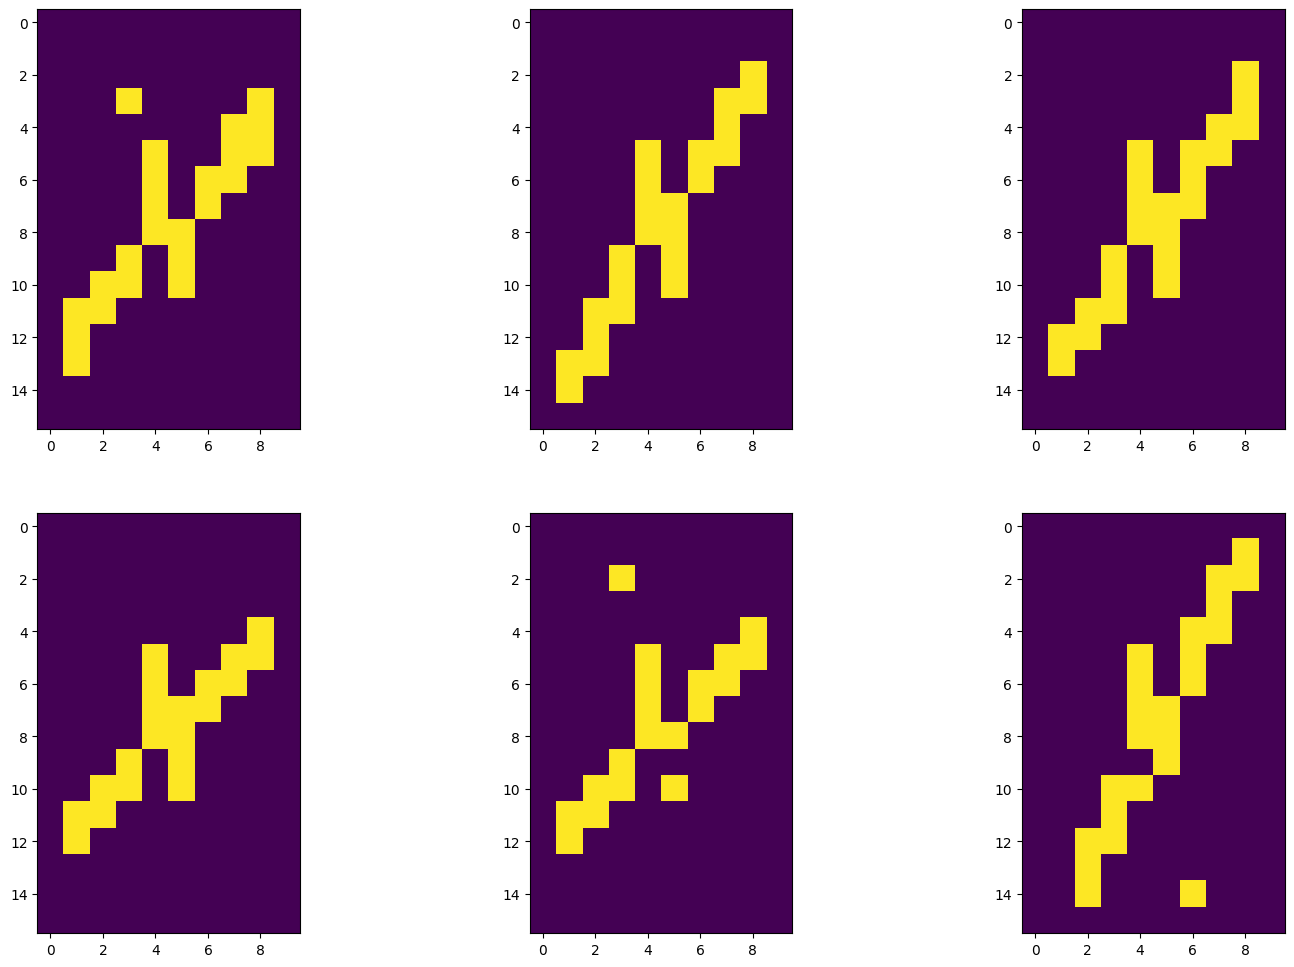

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import a111sdk

# 加载输入数据
in_data = a111sdk.load_csv('data/input_datas.csv')
# 填充输入数据为320行（rram xb 行数）
in_data = a111sdk.trans_pt_data_2_rram(in_data, dac_value=120, data_len=160)
# in_data = a111sdk.trans_pt_data_2_rram(in_data, dac_value=120)

def show_images(imgs, rows, cols, titles=None, scale=6):
    figsize = (cols*scale, rows*scale)
    _, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img)
        if titles:
            ax.set_title(titles[i])
    return axes


# 显示前八张图片，可以用于校验数据集是否选择正确
img_col = 3
img_row = 2
img_size = img_col*img_row
img_data = in_data[0:img_size, :]
show_images(img_data.reshape(img_col*img_row, 16, 10), img_row, img_col)


# 向esram中写入图像数据
test_imgs_num = 100
batch_size = 100
batch_num = test_imgs_num // batch_size
in_addr_esram = 0x0
data_len = 320
data_size = 0

a111sdk.open_a111()

for batch in range(batch_num):
    in_data_batch = in_data[batch*batch_size:(batch+1)*batch_size,:]
    in_data_batch = in_data_batch.flatten()
    data_size = in_data_batch.size
    a111sdk.set_input_to_esram(in_data_batch, in_addr_esram)

    read_data_ = a111sdk.get_value_from_esram(in_addr_esram, data_size)
    
    if (in_data_batch == read_data_).all():
        print(f"batch {batch} read/write successfully!!!")
    else:
        print(f"batch {batch} read/write failed!!!")
        break




a111sdk.close_a111()